### MAPPING AUTHORS POSTS TO THEIR AUTHOR SELF-DECLARED POLITICAL IDEOLOGY

In [7]:
import pandas as pd
import numpy as np

from author_flair_mapping import compatible_categories
def is_author_feasible(author_df: pd.DataFrame, category_col: str = 'author_flair_text', max_span: int =90, include_feasible_categories: bool = False, return_values: bool = False):
    """
    Given the input DataFrame (i.e. the dataframe containing the Political Compass' categories associated to the author' posts and the timestamps of such posts),
    returns True if the author has only one category associated in the first max_span days, otherwise False.
    If include_feasible_categories is True, an author is considered feasible if he always has the same category in any of the dimensions.
    E.G. -> author_categories = [right, authright] -> always right -> will be considered feasible and belonging to the 'Right' category on the economic dimension, None on the social dimension
    """
    valid_author_categories = author_df[author_df[category_col].notna()]
    if valid_author_categories.empty:
        return False if not return_values else (None, None, None)
    first_point = author_df[author_df[category_col].notna()].iloc[0]
    first_date, first_label = first_point['date'], first_point[category_col]
    last_date_to_check = first_date+pd.Timedelta(days=max_span)
    if author_df[category_col].nunique()==1:
        return (author_df[category_col].dropna().iloc[0], first_date, last_date_to_check) if return_values else True
    
    author_categories = author_df.loc[(author_df.date>=first_date) & (author_df.date<=last_date_to_check), category_col]
    
    if include_feasible_categories:
        curr_label = compatible_categories(author_categories.unique())
        return (curr_label, first_date, last_date_to_check) if return_values else bool(curr_label)
    else:
        is_feasible = author_categories.nunique()==1
        return (first_label, first_date, last_date_to_check) if (is_feasible and return_values) else is_feasible

In [8]:
from data_extraction import get_whole_filelist

In [9]:
category_col = 'author_flair_text_str'
polcompass_df = pd.read_parquet('./data/dataset_whole/polcompass_df.parquet').sort_values(by=['author','created_utc','subreddit'])


grpd_feasible_authors = polcompass_df.groupby('author').apply(lambda author_df: is_author_feasible(author_df, category_col=category_col, return_values=True, include_feasible_categories=False))
grpd_feasible_authors = grpd_feasible_authors[grpd_feasible_authors.map(bool)].apply(pd.Series).rename({0:'polcompass_flair',1:'min_date',2:'max_date'},axis=1).dropna()
grpd_feasible_authors

,polcompass_flair,min_date,max_date
author,,,
8,libleft,2022-02-11,2022-05-12
10,authright,2022-02-06,2022-05-07
12,libleft,2022-03-25,2022-06-23
17,libleft,2021-05-29,2021-08-27
21,centrist,2020-12-06,2021-03-06
...,...,...,...
35865,libleft,2021-11-22,2022-02-20
35869,libright,2021-05-19,2021-08-17
35871,libcenter,2022-09-15,2022-12-14


In [10]:
#del(tmp_valid)
"""
Loading political subreddits from reddit politosphere and from Rajadesingan political subreddits list.
Then joining them  (by using either union, or intersection - if use_subreddits_intersection=True)
"""

import re
political_discussion_df = pd.read_csv('./data/political_subreddits_list.csv').rename({'subreddit':'subreddit_pd'} ,axis=1)
political_discussion_df.rename(lambda x: '_'.join(re.split(r"[ :\-()]+", x)), inplace=True, axis=1)

with open('./data/politosphere_subreddits.txt', 'r') as f:
    reddit_politosphere_df = pd.Series(f.read().splitlines(), name='subreddit_ps')
    f.close()
political_subreddits_df = pd.merge(political_discussion_df, reddit_politosphere_df, left_on='subreddit_pd', right_on='subreddit_ps', how='outer')
del(political_discussion_df, reddit_politosphere_df)
#political_subreddits_df.fillna({'subreddit_pd': False, 'subreddit_ps': False}, inplace=True)

use_subreddits_intersection = False
political_freq_treshold = 0.5
political_subreddits = political_subreddits_df.loc[(political_subreddits_df.subreddit_pd.notna()) & (political_subreddits_df['political_comments_%']>political_freq_treshold)] \
                if use_subreddits_intersection \
                else \
                    political_subreddits_df.loc[(political_subreddits_df.subreddit_ps.notna()) | (political_subreddits_df['political_comments_%']>political_freq_treshold)]

#del(political_subreddits_df, use_subreddits_intersection)
political_subreddits = set(political_subreddits.subreddit_pd.dropna().unique()) | set(political_subreddits.subreddit_ps.dropna().unique())

In [24]:
scanned_index_filename = './data/results_gemini_index.pkl'
try:
    scanned_index = pd.read_pickle(scanned_index_filename)
except FileNotFoundError:
    scanned_index = pd.Index([])
scanned_index[:5]

MultiIndex([( 18301.0, 'comment'),
            ( 21166.0, 'comment'),
            (298362.0, 'comment'),
            (391597.0, 'comment'),
            (389914.0, 'comment')],
           names=['content_id', 'content_type'])

In [ ]:
"""
SAVING SAMPLES OF DATA TO MIMIC ALL FUNCTIONALITIES BEHAVIOURS IN GIT PROJECT
"""

from pathlib import Path
Path('./data/dataset_whole/mapped_dataframes').mkdir(exist_ok=True, parents=True)

all_filetypes = set([x.split('_new')[0].split('_')[-1] for x in get_whole_filelist('../data/dataset_whole/mapped_dataframes/', filename_string='10_*_new')])
all_filetypes = [x for x in all_filetypes if x!='orig']
for i in range(5):
    for content in  ['posts', 'comments']:
        curr_orig_filename = f'{content}_chunk_{i}_orig_new.parquet'
        orig_df = pd.read_parquet(f'../data/dataset_whole/mapped_dataframes/{curr_orig_filename}',  filters=[('author', 'in', grpd_feasible_authors.index),
                                   ])
        cols = orig_df.columns
        orig_df = pd.merge(orig_df, grpd_feasible_authors, left_on='author', right_index=True)
        orig_df = orig_df.loc[(orig_df.date>=orig_df.min_date) & (orig_df.date<=orig_df.max_date), cols ]#.drop(columns=['min_date','max_date'])
        #orig_df.sample(frac=0.02).to_parquet(f'./data/dataset_whole/mapped_dataframes/{curr_orig_filename}', index=True)
        
        curr_types_indexes = []
        curr_orig_filename = f'{content}_chunk_{i}_orig_new.parquet'
        orig_df = pd.read_parquet(f'./data/dataset_whole/mapped_dataframes/{curr_orig_filename}')
        curr_types_indexes.append(set(orig_df.index))
        for content_type in all_filetypes:
            curr_type_filename = f'{content}_chunk_{i}_{content_type}_new.parquet'
            curr_type_df = pd.read_parquet(f'../data/dataset_whole/mapped_dataframes/{curr_type_filename}', filters=[(f'{content[:-1]}_id', 'in', orig_df.index)])
            print(curr_orig_filename, curr_type_filename, len(curr_type_df))
            #curr_type_df.to_parquet(f'./data/dataset_whole/mapped_dataframes/{curr_type_filename}')
            curr_types_indexes.append(set(curr_type_df.index))
        any_wrong = any(len(curr_set-curr_types_indexes[0]) for curr_set in curr_types_indexes[1:])
        if any_wrong:
            break
        
    
all_orig_df_p = pd.concat([pd.read_parquet(f'./data/dataset_whole/mapped_dataframes/posts_chunk_{i}_orig_new.parquet') for i in range(50)], axis=0, ignore_index=False)
all_orig_df_p['content_type'] = 'post'
all_orig_df_p= all_orig_df_p.reset_index().rename({'post_id':'content_id'},axis=1).set_index([ 'content_id', 'content_type',])

all_orig_df_c = pd.concat([pd.read_parquet(f'./data/dataset_whole/mapped_dataframes/comments_chunk_{i}_orig_new.parquet') for i in range(50)], axis=0, ignore_index=False)
all_orig_df_c['content_type'] = 'comment'
all_orig_df_c= all_orig_df_c.reset_index().rename({'comment_id':'content_id'},axis=1).set_index([ 'content_id', 'content_type',])
all_orig_df = pd.concat([all_orig_df_p, all_orig_df_c],axis=0, ignore_index=False)

pd.read_parquet('../data/results_gemini.parquet', filters=[('content_type', 'in', all_orig_df.index.get_level_values('content_type')),
                                                           ('content_id', 'in', all_orig_df.index.get_level_values('content_id'))])\
    .to_parquet('./data/results_gemini.parquet')
pd.to_pickle(obj=pd.read_parquet('./data/results_gemini.parquet', columns=[]).index, filepath_or_buffer='./data/results_gemini_index.pkl')

### LOADING TEXTS NOT ALREADY PROCESSED BY GEMINI

In [42]:
from nrclex import NRCLex

nrc = NRCLex('C:/Users/onest/Documents/TextAn/tesi/code/data/utils/NRC-Emotion-Lexicon/NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
a = nrc.load_raw_text('Try this shitty amazing text')
a.top_emotions

[('surprise', 1.0)]

In [12]:
import random

#eng_stopwords = stopwords.words('english')
content_types = ['posts','comments']
texts = pd.DataFrame()

for curr_chunk_i in random.sample(range(50),50):
    common_starting_file = './data/dataset_whole/mapped_dataframes/{}_chunk_{}_{}.parquet'.format('{}', curr_chunk_i, '{}')
    ##ORIGINAL DF (author, author_flair, subreddit, date...)
    orig_df = pd.concat([
        pd.read_parquet(common_starting_file.format(content, 'orig_new'), columns=['author', 'date', 'created_utc', 'subreddit'], 
                        filters=[('author', 'in', grpd_feasible_authors.index),
                               ]).reset_index()  
                for content in content_types], axis=0, ignore_index=True)
    orig_df = pd.merge(orig_df, grpd_feasible_authors, left_on='author', right_index=True)
    orig_df = orig_df[(orig_df.date>=orig_df.min_date) & (orig_df.date<=orig_df.max_date) ].drop(columns=['min_date','max_date'])
    orig_df = orig_df[orig_df.subreddit.str.lower().isin(list(map(str.lower, political_subreddits)))]

    print('Loaded orig... ', curr_chunk_i)
    orig_df['content_id'] = orig_df['post_id'].fillna(orig_df['comment_id'])
    orig_df['content_type'] = np.nan
    orig_df['content_type'] = orig_df['content_type'].fillna(orig_df.loc[orig_df.post_id.notna(), 'post_id'].map(lambda t: 'post')).fillna('comment')

    ###SPLITTING POLCOMPASS AND NON_POLCOMPASS -> DOING IT FOR EACH FILE TO AVOID "TOKENS FILTERING" ON POLCOMPASS TEXTS, SINCE WE WON'T USE THEM
    curr_polcompass_df = orig_df[orig_df.subreddit.str.lower().isin(['politicalcompass','politicalcompassmemes', 'politicalcompassmemes2'])]
    curr_final_df = orig_df[~orig_df.index.isin(curr_polcompass_df.index)]
    del(curr_polcompass_df, orig_df)
    if curr_final_df.empty:
        continue
    textual_df = pd.concat([pd.read_parquet(common_starting_file.format(content, 'textualfiltered_new'), columns=['text'],
                                            filters=[('{}_id'.format(content[:-1]), 'in', curr_final_df['{}_id'.format(content[:-1])].values)]).reset_index() 
                            for content in content_types], axis=0, ignore_index=True)    
    textual_df['content_id'] = textual_df['post_id'].fillna(textual_df['comment_id'])
    textual_df['content_type'] = np.nan
    textual_df['content_type'] = textual_df['content_type'].fillna(textual_df.loc[textual_df.post_id.notna(), 'post_id'].map(lambda t: 'post')).fillna('comment')
    textual_df.drop(columns=['post_id', 'comment_id'], inplace=True)
    print('Loaded textual...')
    curr_final_df = curr_final_df.drop(columns=['post_id', 'comment_id','created_utc'], errors='ignore').merge(textual_df, how='inner', on=['content_id', 'content_type'])[['author','text', 'content_id', 'content_type', 'polcompass_flair']].set_index(['content_id', 'content_type'])
    curr_final_df = curr_final_df[~curr_final_df.index.isin(scanned_index)]
    texts = pd.concat([texts, curr_final_df], axis=0, ignore_index=False)
    del(curr_final_df, textual_df)
    
del(political_subreddits, polcompass_df, political_subreddits_df, grpd_feasible_authors)
#texts = texts.sample(100000)
texts
#df = pd.read_parquet('../Tesi/code/data/dataset_whole/mapped_dataframes/comments_chunk_{}_textualfiltered_new.parquet'.format(curr_chunk_i))#.sample(1)
#df2 = pd.read_parquet('../Tesi/code/data/dataset_whole/mapped_dataframes/comments_chunk_{}_orig_new.parquet'.format(curr_chunk_i))#.sample(1)

#df

Loaded orig...  45
Loaded textual...
Loaded orig...  11
Loaded textual...
Loaded orig...  22
Loaded textual...
Loaded orig...  34
Loaded textual...
Loaded orig...  37
Loaded textual...
Loaded orig...  44
Loaded textual...
Loaded orig...  27
Loaded textual...
Loaded orig...  17
Loaded textual...
Loaded orig...  16
Loaded textual...
Loaded orig...  29
Loaded textual...
Loaded orig...  41
Loaded textual...
Loaded orig...  47
Loaded textual...
Loaded orig...  10
Loaded textual...
Loaded orig...  24
Loaded textual...
Loaded orig...  9
Loaded textual...
Loaded orig...  13
Loaded textual...
Loaded orig...  26
Loaded textual...
Loaded orig...  20
Loaded textual...
Loaded orig...  36
Loaded textual...
Loaded orig...  49
Loaded textual...
Loaded orig...  25
Loaded textual...
Loaded orig...  0
Loaded textual...
Loaded orig...  33
Loaded textual...
Loaded orig...  18
Loaded textual...
Loaded orig...  4
Loaded textual...
Loaded orig...  38
Loaded textual...
Loaded orig...  31
Loaded textual...
Load

,,author,text,polcompass_flair
content_id,content_type,,,
3082942.0,post,32948,Why do you prefer distrbutism over market soci...,left
3082897.0,post,32948,How would market anarchists deal with people w...,left
45296255.0,comment,32976,That’s an absolute patriot move,centrist
45273782.0,comment,32948,"Actually, you can very easily look up the poli...",left
44628821.0,comment,32484,Are you being intentionally dense? Lax fiscal ...,libright
...,...,...,...,...
21940585.0,comment,15480,&gt;they must have gotten close to total satur...,left
21859197.0,comment,15440,Uh guys I got wooshed what am I supposed to be...,authright
22183622.0,comment,15609,"At this point, I'm willing to bet Russia's nuk...",right


In [13]:
results_df_filename = './data/results_gemini.parquet' #set to None to overwrite past results

if results_df_filename is None:
    results_df = pd.DataFrame()
    results_df_filename = './data/results_gemini.parquet'
else:
    try:
        results_df = pd.read_parquet(results_df_filename)
    except FileNotFoundError:
        results_df = None
results_df #texts processed by Gemini

,,text,author,polcompass_flair,Political,HorizontalDimension,VerticalDimension,Populism,PeopleCentrism,AntiElitism,EmotionalAppeal,Libertarian,Authoritarian,Left,Right,Motivazioni,full_response
content_id,content_type,,,,,,,,,,,,,,,,
18301.0,comment,Yes there can be abstract things without objec...,24,libright,NonPolitical,None,None,0.00,0.0,0.00,0.1,0.0,0.0,0.0,0.0,The text is a general statement about abstract...,"Ok, ecco l'analisi del testo fornito:\n\nscore..."
21166.0,comment,"im a straight guy but i'll admit, damn he's hot",27,centrist,NonPolitical,None,None,0.00,0.0,0.00,0.2,0.0,0.0,0.0,0.0,The text is a personal comment about someone's...,score__Political__score:value__NonPolitical__v...
298362.0,comment,"I agree with the comment you were replying to,...",210,libleft,NonPolitical,None,None,0.10,0.2,0.30,0.3,0.1,0.1,0.2,0.1,Il testo si concentra principalmente sulla sti...,"OK, ecco l'output basato sul testo fornito e l..."
391597.0,comment,When facts are opinions...,284,libright,NonPolitical,None,None,0.10,0.1,0.20,0.3,0.0,0.0,0.0,0.0,The short phrase expresses frustration with a ...,score__Political__score:value__NonPolitical__v...
389914.0,comment,Ahhh got it... thats probably because they're ...,284,libright,NonPolitical,None,None,0.00,0.0,0.00,0.1,0.0,0.0,0.0,0.0,The text discusses life expectancy and parenta...,score__Political__score:value__NonPolitical__v...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49587578.0,comment,I'm from Europe so nobody I know has reasons t...,35763,libcenter,Political,Centrist,Centrist,0.30,0.4,0.50,0.3,0.3,0.2,0.3,0.3,"The text discusses Trump being ""outside of the...",score__Political__score:value__Political__valu...
49611632.0,comment,List: GOP Assembly\n\nParty: GOP\n\nDistrict: ...,35781,libright,Political,Right,Authoritarian,0.10,0.2,0.10,0.1,0.2,0.4,0.1,0.6,The text is a simple listing of a GOP (Republi...,score__Political__score:value__Political__valu...
49630825.0,comment,"And he probably said ""The Regulars are coming""...",35790,left,NonPolitical,None,None,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,"The text is a historical comment, discussing t...",score__Political__score:value__NonPolitical__v...


### GEMINI PROMPT - CATEGORIZING TEXTS (AS POLITICAL/NON-POLITICAL, LEFT/RIGHT/CENTRIST, AUTH/LIB/CENTRIST) AND EXTRACTING POPULISM RELATED ATTRIBUTES' VALUES

In [29]:
from google import genai
import time

if "requests_times" not in globals():
    requests_times = []
max_rpm = 15
key = '' ### set your GeminiAPI Key here

client = genai.Client(api_key=key)
prompt = "I'm writing a text below; assign it a category for each of the following tasks (I'll list them as Category: [Set of exclusive possible values], you can assign one and only one value among those listed, for each category. If you can't classify it into any of the categories, classify it as Undefined):\
1. Political: [Political, NonPolitical];\
2. Economic dimension: [Left, Right, Centrist];\
3. Social dimension: [Authoritarian, Libertarian, Centrist].\
\n \
Additionally, I would like you to assign values, on a scale from 0 (not at all) to 1 (completely), for the following attributes:\
populism, people-centrism, antielitism, emotional appeal, libertarian, authoritarian, left, right.\
\
Please consider that the text comes from a Reddit comment and is written in English; also, I want you to consider the following definitions of the attributes:\
\
- Populism as a political ideology that sees society as divided into a good people and an evil elite;\
- people-centrism as the idea that sovereignty should reside exclusively in the hands of ordinary citizens;\
- anti-elitism as the ideology that elites and the establishment are perceived as hostile entities that act against the interest of the people;\
- emotional appeal: political communication that frequently appeals to emotions rather than rational arguments.\
\
Return the output using the following format:\\ (By using the structure: score__Attribute__score : value__Value__value) \
    score__Political__score:value__True__value \
    score__HorizontalDimension__score:value__Left__value \
    score__VerticalDimension__score:value__Auth__value \
    score__Populism__score:value__0.2__value \
    score__PeopleCentrism__score:value__0.4__value \
    score__AntiElitism__score:value__0.2__value \
    score__EmotionalAppeal__score:value__0.6__value \
    score__Libertarian__score:value__0.3__value \
    score__Authoritarian__score:value__0.2__value \
    score__Left__score:value__0.45__value \
    score__Right__score:value__0.05__value \
    score__Motivazioni__score:value__Testo che spiega le motivazioni__value \
    The text is attached below (between [START_TEXT] and [END_TEXT]): \
    [START_TEXT]\n {} \n[END_TEXT]"

saving_batch_size = 150 ##set it to change number of texts to store on disk after gemini analysis
for curr_row in texts.itertuples():
    curr_ind, curr_text, curr_author, curr_pcflair = curr_row.Index, curr_row.text, curr_row.author, curr_row.polcompass_flair
    if curr_ind in results_df.index:
        continue
        
    response, sleeptime, missed_responses_count =  False, 5, 0
    while not response:
        if missed_responses_count>40:
            break
        try:
            curr_request_time = time.time()
            last_valid_request_time = requests_times[-max_rpm] if len(requests_times)>=max_rpm else curr_request_time-61
            #if (request_time_diff := curr_request_time - last_valid_request_time) < 60:
            #    print('Too many rpm... waiting: %.2fs' %(request_time_diff))
            #    time.sleep(request_time_diff+1)
            requests_times.append(curr_request_time)
            requests_times = requests_times[-15:]
            response = client.models.generate_content(
                model="gemini-2.0-flash",
                contents=prompt.format(curr_text) )
            print(f'Analyzed text at time {curr_request_time}')
        except Exception as e: 
            missed_responses_count += 1
            print(e, '\t retrying in %.2fs' %(sleeptime))
            time.sleep(sleeptime)
            sleeptime+=2
    try:
        structured_response = {}
        structured_response = dict(map(lambda elem: re.split('__score\s*:\s*value__', elem), re.findall('score__[^\t\n\r\f\v]*__value(?:\s+|$)', response.text)))
        
    finally:
        if set(structured_response) != {'score__AntiElitism',
         'score__Authoritarian',
         'score__EmotionalAppeal',
         'score__HorizontalDimension',
         'score__Left',
         'score__Libertarian',
         'score__Motivazioni',
         'score__PeopleCentrism',
         'score__Political',
         'score__Populism',
         'score__Right',
         'score__VerticalDimension'}:
            try:
                structured_response = dict(map(lambda elem: re.split('__score\W*:\W*value__', elem), re.findall('score__[^\t\n\r\f\v]*__value', response.text)))
            except (IndexError, ValueError):
                pass
        structured_response = {k.split('score__')[1]:v.split('__value')[0] for k,v in structured_response.items()}
        structured_response['full_response'] = response.text
        structured_response['text'] = curr_text
        structured_response['author'] = curr_author
        structured_response['polcompass_flair'] = curr_pcflair

    results_df = pd.concat([results_df, pd.DataFrame(pd.Series(structured_response, name=curr_ind)).T], axis=0, ignore_index=False)
    if (len(results_df)%saving_batch_size)==0 and not results_df.empty:
        results_df.index.names = texts.index.names
        results_df.to_parquet(results_df_filename)
        print('Saved after %d requests' %len(results_df))


results_df.index.names = texts.index.names
results_df.to_parquet(results_df_filename)
results_df

<>:70: SyntaxWarning: invalid escape sequence '\s'
<>:70: SyntaxWarning: invalid escape sequence '\s'
<>:86: SyntaxWarning: invalid escape sequence '\W'
<>:70: SyntaxWarning: invalid escape sequence '\s'
<>:70: SyntaxWarning: invalid escape sequence '\s'
<>:86: SyntaxWarning: invalid escape sequence '\W'
C:\Users\onest\AppData\Local\Temp\ipykernel_15056\3643768614.py:70: SyntaxWarning: invalid escape sequence '\s'
  structured_response = dict(map(lambda elem: re.split('__score\s*:\s*value__', elem), re.findall('score__[^\t\n\r\f\v]*__value(?:\s+|$)', response.text)))
C:\Users\onest\AppData\Local\Temp\ipykernel_15056\3643768614.py:70: SyntaxWarning: invalid escape sequence '\s'
  structured_response = dict(map(lambda elem: re.split('__score\s*:\s*value__', elem), re.findall('score__[^\t\n\r\f\v]*__value(?:\s+|$)', response.text)))
C:\Users\onest\AppData\Local\Temp\ipykernel_15056\3643768614.py:86: SyntaxWarning: invalid escape sequence '\W'
  structured_response = dict(map(lambda elem: 

Analyzed text at time 1754145489.5549998
Analyzed text at time 1754145495.4935737


C:\Users\onest\AppData\Local\Temp\ipykernel_15056\3643768614.py:70: SyntaxWarning: invalid escape sequence '\s'
  structured_response = dict(map(lambda elem: re.split('__score\s*:\s*value__', elem), re.findall('score__[^\t\n\r\f\v]*__value(?:\s+|$)', response.text)))
C:\Users\onest\AppData\Local\Temp\ipykernel_15056\3643768614.py:70: SyntaxWarning: invalid escape sequence '\s'
  structured_response = dict(map(lambda elem: re.split('__score\s*:\s*value__', elem), re.findall('score__[^\t\n\r\f\v]*__value(?:\s+|$)', response.text)))
C:\Users\onest\AppData\Local\Temp\ipykernel_15056\3643768614.py:86: SyntaxWarning: invalid escape sequence '\W'
  structured_response = dict(map(lambda elem: re.split('__score\W*:\W*value__', elem), re.findall('score__[^\t\n\r\f\v]*__value', response.text)))


KeyboardInterrupt: 

In [ ]:
##EXPLICITLY MAPPING COLUMNS TO PROPER DTYPES AND SAVING FINAL RESULTS
results_df = pd.read_parquet(results_df_filename).drop_duplicates()
results_df.Populism = results_df.Populism.astype(float)
results_df.AntiElitism = results_df.AntiElitism.astype(float)
results_df.PeopleCentrism = results_df.PeopleCentrism.astype(float)
results_df.EmotionalAppeal = results_df.EmotionalAppeal.astype(float)
results_df.Libertarian = results_df.Libertarian.astype(float)
results_df.Authoritarian = results_df.Authoritarian.astype(float)
results_df.Left = results_df.Left.astype(float)
results_df.Right = results_df.Right.astype(float)

results_df.index.names = texts.index.names

results_df.reindex(['text','author', 'polcompass_flair', 'Political', 'HorizontalDimension',
       'VerticalDimension', 'Populism', 'PeopleCentrism', 'AntiElitism',
       'EmotionalAppeal', 'Libertarian', 'Authoritarian', 'Left', 'Right',
       'Motivazioni', 'full_response', ], axis=1).sort_index().sort_values(by='author').drop_duplicates().to_parquet(results_df_filename)

##STORING INDEX
index_filename = '_index'.join(results_df_filename.split('.parquet'))+'.pkl'

scanned_index = pd.read_parquet(whole_filename).index
pd.to_pickle(obj=scanned_index, filepath_or_buffer=index_filename)

#### ANALYSING GEMINI CLASSIFICATION WRT TEXTS POLITICAL CATEGORIES ASSIGNED THROUGH AUTHORS' DECLARED POLITICAL IDEOLOGY

In [14]:
from author_flair_mapping import map_mother_categories
gemini_df = pd.read_parquet('./data/results_gemini.parquet')
category_col = 'polcompass_flair'

gemini_df.Populism = gemini_df.Populism.astype(float)
gemini_df.AntiElitism = gemini_df.AntiElitism.astype(float)
gemini_df.PeopleCentrism = gemini_df.PeopleCentrism.astype(float)
gemini_df.EmotionalAppeal = gemini_df.EmotionalAppeal.astype(float)
gemini_df.Libertarian = gemini_df.Libertarian.astype(float)
gemini_df.Authoritarian = gemini_df.Authoritarian.astype(float)
gemini_df.Left = gemini_df.Left.astype(float)
gemini_df.Right = gemini_df.Right.astype(float)

mapping_gemini = {'Right': 'right', 'Left': 'left', 'Centrist':'centrist', 'Libertarian':'lib', 'Authoritarian':'auth', 'Centrist':'centrist', 'None':None, 'Political':True, 'NonPolitical':False}
def mapping_gemini_cat(curr_cat):
    """dimension = author_flair_mapping.__map_to_valid_dimension__(dimension)
    if dimension is None:
        raise ValueError('Dimension is not correct')
    curr_mapping = h_mapping_gemini if dimension==author_flair_mapping.HORIZONTAL_DIMENSION else v_mapping_gemini if dimension==author_flair_mapping.VERTICAL_DIMENSION else {}
    """
    return mapping_gemini.get(curr_cat, curr_cat)
    
    
gemini_df['Political'] = gemini_df.Political.map(mapping_gemini_cat)#.fillna(df['HorizontalDimension'])
gemini_df['HorizontalDimension'] = gemini_df.HorizontalDimension.map(mapping_gemini_cat)#.fillna(df['HorizontalDimension'])
gemini_df['VerticalDimension'] = gemini_df.VerticalDimension.map(mapping_gemini_cat)

gemini_df = map_mother_categories(gemini_df.copy(), category_col).reindex(['text','author', 'polcompass_flair', 
        'horizontal_polcompass_flair', 'vertical_polcompass_flair', 'Political', 'HorizontalDimension',
       'VerticalDimension', 'Populism', 'PeopleCentrism', 'AntiElitism',
       'EmotionalAppeal', 'Libertarian', 'Authoritarian', 'Left', 'Right',
       'Motivazioni', 'full_response', ], axis=1).sort_index().sort_values(by='author')

###SHOWING THE POLITICAL PREDICTED CATEGORIES OF THE TEXTS BY THE GEMINI MODEL
for dimension in ['vertical', 'horizontal']:
    print(gemini_df.groupby(f'{dimension}_{category_col}')[f'{dimension.capitalize()}Dimension'].value_counts(dropna=False))



vertical_polcompass_flair  VerticalDimension
auth                       NaN                  190
                           centrist              67
                           auth                  52
                           lib                   26
centrist                   NaN                   91
                           centrist              41
                           auth                  11
                           lib                    9
lib                        NaN                  507
                           centrist             231
                           lib                  171
                           auth                  64
Name: count, dtype: int64
horizontal_polcompass_flair  HorizontalDimension
centrist                     NaN                    270
                             centrist                93
                             left                    61
                             right                   56
left                         NaN

In [15]:
## WHAT IS THE NUMBER OF TEXTS CLASSIFIED AS POLITICAL?
## WHAT IS THE POLITICAL CATEGORY ASSIGNED BY GEMINI TO EACH TEXT , ON EACH DIMENSION?
## HOW MANY TEXTS GET CLASSIFIED AS "None"? HOW MANY TEXTS ARE MISLABELED WRT SELF-DECLARED CATEGORY?
print(pd.concat([gemini_df.Political.value_counts(), gemini_df.Political.value_counts(normalize=True)], axis=1, ignore_index=False)) #political vs non-polit

print(pd.concat([gemini_df.HorizontalDimension.value_counts(dropna=False), gemini_df.HorizontalDimension.value_counts(normalize=True ,dropna=False)], axis=1, ignore_index=False)) #economic dim

print(pd.concat([gemini_df.VerticalDimension.value_counts(dropna=False), gemini_df.VerticalDimension.value_counts(normalize=True, dropna=False)], axis=1, ignore_index=False)) #social dim


           count  proportion
Political                   
True         912    0.535526
False        791    0.464474
                     count  proportion
HorizontalDimension                   
None                   937    0.542245
right                  274    0.158565
centrist               273    0.157986
left                   244    0.141204
                   count  proportion
VerticalDimension                   
None                 947    0.548032
centrist             406    0.234954
lib                  225    0.130208
auth                 150    0.086806


In [16]:
##N OF Nones strictly dependent from "Political" value (i.e. >95% non-Political Texts are categorized as None, vs <20% of Political Texts)

print(gemini_df.groupby('Political')['HorizontalDimension'].apply(lambda x: pd.concat([x.value_counts(dropna=False), x.value_counts(dropna=False, normalize=True)],
                                                                                   axis=1, ignore_index=False)) )

print(gemini_df.groupby('Political')['VerticalDimension'].apply(lambda x: pd.concat([x.value_counts(dropna=False), x.value_counts(dropna=False, normalize=True)],
                                                                                   axis=1, ignore_index=False)) )

                    count  proportion
Political                            
False     NaN         758    0.958281
          centrist     28    0.035398
          right         4    0.005057
          left          1    0.001264
True      right       270    0.296053
          centrist    245    0.268640
          left        242    0.265351
          NaN         155    0.169956
                    count  proportion
Political                            
False     NaN         746    0.943110
          lib          26    0.032870
          centrist     17    0.021492
          auth          2    0.002528
True      centrist    388    0.425439
          lib         199    0.218202
          NaN         177    0.194079
          auth        148    0.162281


In [17]:
###SHOWING CONFUSION MATRIX AND CLASSIFICATION REPORT
### HOW DID GEMINI CATEGORIZE TEXTS? (i.e. given a text' category through the declared author's ideology, what's the predicted category of such text by Gemini?)
### CONFUSION MATRIX -> text' author's declared ideology vs gemini prediction
from sklearn.metrics import confusion_matrix, classification_report
classes_by_dim = {'horizontal': gemini_df['horizontal_polcompass_flair'].unique().tolist(), 'vertical': gemini_df['vertical_polcompass_flair'].unique().tolist()}
for dimension in classes_by_dim:
    classes = classes_by_dim[dimension] + [None, 'Undefined', np.nan]
    correctly_predicted_df = gemini_df[(gemini_df['{}Dimension'.format(dimension.capitalize())].isin(classes)) & (gemini_df['{}_polcompass_flair'.format(dimension)].notna())]
    print(classification_report(correctly_predicted_df['{}_polcompass_flair'.format(dimension)], correctly_predicted_df['{}Dimension'.format(dimension.capitalize())].fillna('Undefined')))
    print(confusion_matrix(correctly_predicted_df['{}_polcompass_flair'.format(dimension)], correctly_predicted_df['{}Dimension'.format(dimension.capitalize())].fillna('Undefined')))

              precision    recall  f1-score   support

   Undefined       0.00      0.00      0.00         0
    centrist       0.34      0.19      0.25       480
        left       0.49      0.20      0.29       586
       right       0.60      0.25      0.35       662

    accuracy                           0.22      1728
   macro avg       0.36      0.16      0.22      1728
weighted avg       0.49      0.22      0.30      1728

[[  0   0   0   0]
 [270  93  61  56]
 [316  97 119  54]
 [351  83  64 164]]
              precision    recall  f1-score   support

   Undefined       0.00      0.00      0.00         0
        auth       0.41      0.16      0.23       335
    centrist       0.12      0.27      0.17       152
         lib       0.83      0.18      0.29       973

    accuracy                           0.18      1460
   macro avg       0.34      0.15      0.17      1460
weighted avg       0.66      0.18      0.26      1460

[[  0   0   0   0]
 [190  52  67  26]
 [ 91  11  41  

C:\Users\onest\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\onest\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\onest\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [18]:
##only analysing the correctly predicted categories (i.e. assuming the self-declared political ideology of the author always corresponds to the text political category)
curr_dataset = gemini_df[(gemini_df.HorizontalDimension==gemini_df.horizontal_polcompass_flair.fillna('centrist')) | (gemini_df.VerticalDimension==gemini_df.vertical_polcompass_flair.fillna('centrist'))]
### SHOWING NUMBER OF CORRECTLY PREDICTED TEXTS' FROM GEMINI ON EACH DIMENSION - BY EACH CATEGORY
for dimension in ['horizontal', 'vertical', 'global']:
    curr_category_col = category_col if dimension=='global' else dimension+'_'+category_col
    if dimension=='global':
        print(curr_dataset.loc[(curr_dataset['horizontal_'+curr_category_col]==curr_dataset['HorizontalDimension']) & (curr_dataset['vertical_'+curr_category_col]==curr_dataset['VerticalDimension']), curr_category_col].value_counts(dropna=False))
    else:
        print(curr_dataset.loc[curr_dataset[curr_category_col]==curr_dataset['{}Dimension'.format(dimension.capitalize())], curr_category_col].value_counts(dropna=False))

horizontal_polcompass_flair
right       164
left        119
centrist     93
Name: count, dtype: int64
vertical_polcompass_flair
lib         171
auth         52
centrist     41
Name: count, dtype: int64
polcompass_flair
libright     51
libleft      30
centrist     27
authright    19
libcenter    13
authleft      7
Name: count, dtype: int64


### ASSIGNING 'UNDEFINED' POLITICAL CATEGORY TO THE TEXTS THAT HAVE BEEN CATEGORIZED AS SUCH FROM GEMINI 

In [19]:
political_only=False

undefined_dataset_h = gemini_df[(gemini_df.HorizontalDimension.fillna('None').isin([None, 'none', 'None'])) & (gemini_df[['Left', 'Right']].max(axis=1)<=0.2) ]
#undefined_dataset_h.loc[undefined_dataset_h.index, [category_col, 'HorizontalDimension', 'horizontal_'+category_col ]] = 'Undefined'
undefined_dataset_v = gemini_df[(gemini_df.VerticalDimension.fillna('None').isin([None, 'none', 'None'])) & (gemini_df[['Libertarian', 'Authoritarian']].max(axis=1)<=0.2) ]
#undefined_dataset_v.loc[undefined_dataset_v.index, [category_col, 'VerticalDimension', 'vertical_'+category_col, ]] = 'Undefined'
undefined_dataset = pd.concat([undefined_dataset_h, undefined_dataset_v],axis=0, ignore_index=False)
undefined_dataset.loc[undefined_dataset_h.index, [category_col, 'HorizontalDimension', 'horizontal_'+category_col ]] = 'Undefined'
undefined_dataset.loc[undefined_dataset_v.index, [category_col, 'VerticalDimension', 'vertical_'+category_col, ]] = 'Undefined'
undefined_dataset.loc[undefined_dataset_h.index.join(undefined_dataset_v.index , how='inner'), [category_col, 'HorizontalDimension', 'horizontal_'+category_col,  'VerticalDimension', 'vertical_'+category_col,]] = 'Undefined'
undefined_dataset.drop_duplicates(inplace=True)
del(undefined_dataset_h, undefined_dataset_v)
"""
undefined_dataset = df[(df.HorizontalDimension.fillna('None').isin([None, 'none', 'None'])) & (df.VerticalDimension.fillna('None').isin([None, 'none', 'None'])) & (df[['Libertarian', 'Authoritarian', 'Left', 'Right']].max(axis=1)<0.2) ]
undefined_dataset.loc[undefined_dataset.index, [category_col, 'VerticalDimension', 'HorizontalDimension', 'horizontal_'+category_col, 'vertical_'+category_col, ]] = 'Undefined'
"""

#df.loc[undefined_dataset.index, :] = undefined_dataset.copy()
undefined_dataset = gemini_df[(gemini_df.HorizontalDimension==gemini_df.horizontal_polcompass_flair) | (gemini_df.VerticalDimension==gemini_df.vertical_polcompass_flair)]
curr_dataset = pd.concat([curr_dataset, undefined_dataset], axis=0, ignore_index=False).sort_index()
curr_dataset.loc[undefined_dataset.index, :] = undefined_dataset.copy()
curr_dataset.drop_duplicates(inplace=True)
if political_only:
    curr_dataset = curr_dataset[curr_dataset.Political==True]
#del(undefined_dataset)
if (curr_dataset.index.value_counts()>1).any():
    raise ValueError('Wrong index')
curr_dataset.head()

,,text,author,polcompass_flair,horizontal_polcompass_flair,vertical_polcompass_flair,Political,HorizontalDimension,VerticalDimension,Populism,PeopleCentrism,AntiElitism,EmotionalAppeal,Libertarian,Authoritarian,Left,Right,Motivazioni,full_response
content_id,content_type,,,,,,,,,,,,,,,,,,
197749.0,post,Glenn Greenwald - The DOJ completely failed to...,2455,libleft,left,lib,True,left,lib,0.6,0.7,0.8,0.7,0.7,0.2,0.7,0.10,"The text criticizes the DOJ and FBI, highlight...",score__Political__score:value__Political__valu...
565947.0,post,How texaco helped franco win the spanish civil...,6431,authleft,left,auth,True,left,None,0.3,0.4,0.5,0.6,0.1,0.6,0.5,0.05,"Il testo è chiaramente politico, riferendosi a...","Ok, ecco l'output basato sul testo fornito e l..."
626798.0,comment,"To say that libertarians, conservatives and fa...",464,right,right,None,True,centrist,centrist,0.1,0.2,0.1,0.7,0.2,0.1,0.2,0.20,The text expresses political opinions by compa...,score__Political__score:value__Political__valu...
648512.0,post,Viva la révolution!,7273,libleft,left,lib,True,left,lib,0.6,0.7,0.7,0.8,0.6,0.1,0.6,0.10,"The phrase ""Viva la révolution!"" is inherently...","Ok, ecco l'analisi del testo fornito, nel form..."
696748.0,post,Concern about JPs embrace of a neocon like Dan...,7677,libright,right,lib,True,right,lib,0.6,0.5,0.7,0.6,0.6,0.3,0.2,0.70,The text expresses concern about Jordan Peters...,"```json\n{\n ""score__Political__score"": ""va..."


In [20]:
##showing n. of texts by category and n. of correctly predicted texts by gemini

for dimension in ['global']:
    tmp_df = curr_dataset.loc[(curr_dataset['VerticalDimension']==curr_dataset['vertical_polcompass_flair']) | (curr_dataset['HorizontalDimension']==curr_dataset['horizontal_polcompass_flair'])]
    tmp_df = tmp_df.loc[(tmp_df['VerticalDimension'].fillna('centrist')==tmp_df['vertical_polcompass_flair'].fillna('centrist')) & (tmp_df['HorizontalDimension'].fillna('centrist')==tmp_df['horizontal_polcompass_flair'].fillna('centrist'))]  
    tmp_df = pd.concat([gemini_df.polcompass_flair.value_counts(dropna=False).rename('n_texts'), tmp_df[category_col].value_counts().rename('n_correct_predictions').astype(int)], axis=1, ignore_index=False)
    #tmp_df['correct_predictions_perc'] = tmp_df['n_correct_predictions']/tmp_df['n_texts']
    tmp_df.sort_values(by='n_correct_predictions', ascending=False, inplace=True)
    print(tmp_df)
    
for dimension in ['vertical', 'horizontal']:
    curr_cat_col = dimension+'_'+category_col
    tmp_df = curr_dataset.loc[curr_dataset[curr_cat_col]==curr_dataset['{}Dimension'.format(dimension.capitalize())]]
    tmp_df = pd.concat([gemini_df[curr_cat_col].value_counts(dropna=False).rename('n_texts'), tmp_df[curr_cat_col].value_counts().rename('n_correct_predictions').astype(int)], axis=1, ignore_index=False)
    #tmp_df['correct_predictions_perc'] = tmp_df['n_correct_predictions']/tmp_df['n_texts']
    tmp_df.sort_values(by='n_correct_predictions', ascending=False, inplace=True)
    print(tmp_df)

                  n_texts  n_correct_predictions
polcompass_flair                                
libright              415                     51
libleft               340                     30
centrist              152                     27
authright             108                     19
left                  129                     16
right                 139                     15
libcenter             218                     15
authleft              117                      7
authcenter            110                      2
                           n_texts  n_correct_predictions
vertical_polcompass_flair                                
lib                            973                  171.0
auth                           335                   52.0
centrist                       152                   41.0
None                           268                    NaN
                             n_texts  n_correct_predictions
horizontal_polcompass_flair                          

auth          0.0
centrist    480.0
left        586.0
lib           0.0
right       662.0
Name: 0, dtype: float64
auth        335.0
centrist    152.0
left          0.0
lib         973.0
right         0.0
Name: 1, dtype: float64


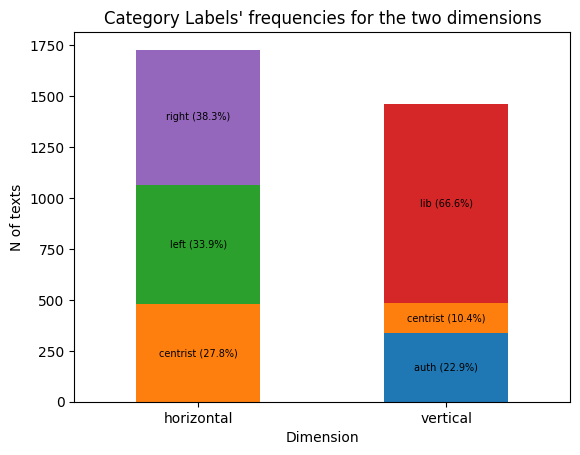

In [21]:
##Showing categories distribution for the correctly categorized texts

import matplotlib.pyplot as plt # Get value counts for each column
h_counts = gemini_df['horizontal_polcompass_flair'].value_counts()
v_counts = gemini_df['vertical_polcompass_flair'].value_counts()

# Combine into a single DataFrame
combined = pd.DataFrame({'horizontal_polcompass_flair': h_counts, 'vertical_polcompass_flair': v_counts}).fillna(0)

#h_counts.index = [f'h_{i}' for i in h_counts.index]
#v_counts.index = [f'v_{i}' for i in v_counts.index]

combined = pd.DataFrame({0: h_counts, 1: v_counts}).fillna(0)

# Plot stacked bar chart
ax = combined.T.plot(kind='bar', stacked=True, legend=False)

# Add text labels directly on the bars
for idx, row in combined.T.iterrows():
    print(row)
    y_offset = 0
    for cat in combined.index:
        val = row[cat]
        if val > 0:
            curr_perc = val / row.sum()
            curr_perc = str((curr_perc * 100).round(1)) + '%'
            ax.text(
                x=idx, 
                y=y_offset + val / 2, 
                s=cat + ' ({})'.format(curr_perc), 
                rotation='horizontal', 
                va='center', 
                ha='center', 
                fontsize=7
            )
            y_offset += val

# Formatting
ax.set_xticklabels(['horizontal', 'vertical'], rotation='horizontal')
plt.xlabel('Dimension')

plt.ylabel('N of texts')
plt.title("Category Labels' frequencies for the two dimensions")
plt.show()
